In [1]:
%matplotlib inline  
#%matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import scipy.integrate as integrate

In [2]:
def create_matrix(R,T,H,dt,mode="base_temp"):
    """
    Ouputs tridag and source coefficients necessary
    to solve the tridiagonal matrix system
    """ 
    n = T.shape[1]
    dr = R[1]-R[0]
    D = [1e-6 for k in range(n+1)] #n+1 because we enter T[:n-1]
    Cp = [1000 for k in range(n+1)]
    
    Diagonals = np.zeros((4,n))
    if mode == "base_temp":
        Diagonals[0,0] = 0   # ct
        Diagonals[1,0] = 1 # bt
        Diagonals[2,0] = 0   # at
        Diagonals[3,0] = T[0,0]+H[0]*dt/Cp[0] 
    
    elif mode == "base_flux":
        Diagonals[0,0] = -D[0]*dt/(R[1]-R[0])**2     # ct
        Diagonals[1,0] = 1/2 +D[0]*dt/(R[1]-R[0])**2 # bt
        Diagonals[2,0] = 0                           # at
        Diagonals[3,0] = 0.5*T[0,0]+H[0]*dt/2/Cp[0]  # st
    
    for i in range(1,n-1):
        Dp = (D[i]+D[i+1])/2 # D_i+1/2
        Dm = (D[i-1]+D[i])/2 # D_i-1/2
        
        Diagonals[0,i] = -dt/(R[i+1]-R[i-1])*(D[i]/R[i] + Dp/(R[i+1]-R[i]))#DiagU
        Diagonals[1,i] = 0.5 + dt/(R[i+1]-R[i-1])*(Dp/(R[i+1]-R[i]) + Dm/(R[i]-R[i-1]))
        Diagonals[2,i] = dt/(R[i+1]-R[i-1])*(D[i]/R[i] - Dm/(R[i]-R[i-1])) #DiagL   
        Diagonals[3,i] = 0.5*T[0,i]+H[i]*dt/2/Cp[i]
    
    Diagonals[0,n-1] = 0
    Diagonals[1,n-1] = 1
    Diagonals[2,n-1] = 0
    Diagonals[3,n-1] = T[0,n-1] #H[n-1]*dt/Cp[n-1] 
    
    return(Diagonals)

In [3]:
def tridag(at,bt,ct,rt,u):
    """
    Solve tridiagonal matrix M*u=rt
    n is the size of the square matrix
    returns the solution vector u
    """
    n = np.size(rt)
    gamt = [0 for k in range(n)]
 
    bett = bt[0]
    u[0] = rt[0]/bett
    for j in range(1,n):
        gamt[j] = ct[j-1] / bett
        bett = bt[j]-at[j]*gamt[j]
        u[j] = (rt[j]-at[j]*u[j-1]) / bett
    
    for j in range(n-2,-1,-1):
        u[j] = u[j]-gamt[j+1]*u[j+1]  
    return(u)

In [4]:
def start_conduction(R, T, H ,time=0.1, dt=0.001, n=50, mode="base_temp"):

    # Loop over timesteps
    for i in range(int(time/dt)):
        T[0,:] = T[1,:]
        #print('time = {}'.format((i+1)*dt))
        Diagonals = create_matrix(R,T[:,:],H,dt,mode) # Create tridag system of equations 
        T[1,:] = tridag(Diagonals[2],Diagonals[1],Diagonals[0],Diagonals[3],T[1,:]) # Solve system
        
    return(T)

---
### Run conduction

In [7]:
# Import temperature
filename = "../Outputs/Tcrust_profile.txt"
data_T = pd.read_csv(filename, skipinitialspace=True, sep=" ",index_col=False,names=["T"])

In [14]:
# Time parameters
time =  0.1 *1e6*365*86400
dt = 0.001 *1e6*365*86400

# Radius and Heat
nlay = int(data["n"][0]/5) #nbr of discrete radius in the crust
n = nlay
R = data["R"][:].to_numpy()[nlay*4:]
H = data["H"][:].to_numpy()[nlay*4:]
rho = 2900
H = H/rho

# Temperature profile
T = np.zeros((2,n))
T_ini = data_T["T"].to_numpy()
T[1]=T_ini

#Call function
T = start_conduction(R, T, H, time, dt, n, mode="base_temp")

In [41]:
np.savetxt("Tcrust_profile.txt",T[1])

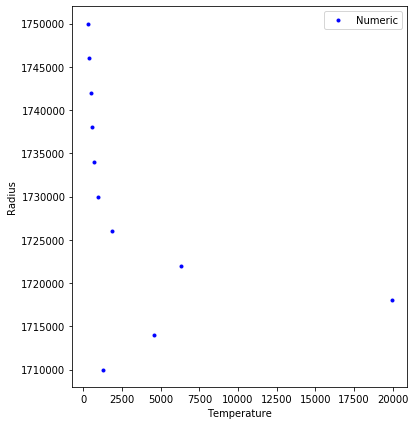

In [57]:
#Plot
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(T[1,:],R,'.',color='blue', label = "Numeric")
ax.set_ylabel("Radius")
ax.set_xlabel(r"Temperature")
plt.legend()
plt.savefig("../figures/Tcrust_profile.png")
#plt.show()

In [2]:
import numpy as np

In [43]:
n = 100
R_base,R_surf = 1710*1e3, 1750*1e3
step = (R_surf-R_base)/n
R = [R_base +step*k for k in range(n+1)]
print(R[:3],"...",R[-3:])

[1710000.0, 1710400.0, 1710800.0] ... [1749200.0, 1749600.0, 1750000.0]


In [46]:
vol = 0
for i in range(n):
    vol += 4*np.pi*((R[i]+R[i+1])/2)**2*(R[i+1]-R[i])
    
print("Calculated vol =  ", vol)
print("Exact vol = ", 4/3*np.pi*(R[-1]**3-R[0]**3))

Calculated vol =   1.504462638409835e+18
Exact vol =  1.5044626451118991e+18


In [39]:
R[-1]

1750000.0